In [1]:
import mrcfile 

import numpy as np
import matplotlib.pyplot as plt

import fsc_utils as fsc

In [2]:
cmap_a = [plt.get_cmap('tab20c').colors[idx] for idx in [0, 4, 8, 12]]
cmap_b = [plt.get_cmap('tab20c').colors[idx] for idx in [2, 6, 10, 12]]

In [3]:
# You will need the 3-D volume and mask from: https://www.ebi.ac.uk/emdb/EMD-11657

map_file = ''
mask_file = ''
    
with mrcfile.open(map_file) as mrc:
    x = mrc.data
    voxel = mrc.voxel_size.x
    mrc.close()
    
with mrcfile.open(mask_file) as mrc:
    mask = mrc.data
    voxel = mrc.voxel_size.x
    mrc.close()    

In [4]:
np.random.seed(0)

snr = 30
B_signal = 100
B_noise = 0

x = x * mask

x = fsc.fourier_downsample(x, 1.5)
r = x.shape[0]//2

y1 = fsc.generate_noisy_data(x, voxel, snr, B_signal, B_noise, return_noise=False)

In [5]:
s1 = y1[:, :, ::2]
s2 = y1[:, :, 1::2]
S2 = fsc.phase_shift_3d(np.fft.fftshift(np.fft.fftn(s2)), 0.5, 0, 0)
s2_shift = np.fft.ifftn(np.fft.ifftshift(S2)).real

s3 = y1[:, ::2, :]
s4 = y1[:, 1::2, :]
S4 = fsc.phase_shift_3d(np.fft.fftshift(np.fft.fftn(s4)), 0, 0.5, 0)
s4_shift = np.fft.ifftn(np.fft.ifftshift(S4)).real

s5 = y1[::2, :, :]
s6 = y1[1::2, :, :]
S6 = fsc.phase_shift_3d(np.fft.fftshift(np.fft.fftn(s6)), 0, 0, 0.5)
s6_shift = np.fft.ifftn(np.fft.ifftshift(S6)).real

In [6]:
c1 = fsc.two_volume_fsc(s1, s2_shift, r)
c2 = fsc.two_volume_fsc(s3, s4_shift, r)
c3 = fsc.two_volume_fsc(s5, s6_shift, r)

c_avg = np.mean([c1, c2, c3], axis=0)

freq = fsc.get_radial_spatial_frequencies(s1, 1)

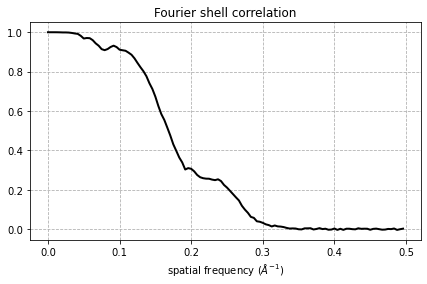

In [7]:
plt.figure(figsize=(7,4))
# plt.plot(freq, c1, color=cmap_a[0], linewidth=2, label='split row')
# plt.plot(freq, c3, color=cmap_a[2], linewidth=2, label='split layer')
# plt.plot(freq, c2, color=cmap_a[3], linewidth=2, label='split column')
plt.plot(freq, c_avg, color='k', linestyle='-', linewidth=2, label='average')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=11)
plt.grid(which='major', linestyle='--')
plt.xlabel('spatial frequency 'r'(${\AA}^{-1}$)')
plt.title('Fourier shell correlation')
# plt.legend()
# plt.savefig('')
plt.show()